In [84]:
import os, json
import pandas as pd
import json 
import plotly.express as px
from IPython.display import Image
from unidecode import unidecode

import regex as re
re.DEFAULT_VERSION = re.VERSION1

import gc
import string
import time
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from gensim.models.callbacks import CallbackAny2Vec
from polyleven import levenshtein
import spacy
import numpy as np
import pickle

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# WSD Using Word2Vec 

In [140]:
textDf = pd.read_csv('data/le_figaro.csv')

## Training model

In [141]:
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0
        self.losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        self.losses.append(loss if (self.epoch == 0) else loss-self.loss_previous_step)
        print('Loss after epoch {}: {}'.format(self.epoch, self.losses[-1]))
        self.epoch += 1
        self.loss_previous_step = loss

In [145]:
# set space between word and punctuation, remove dash and unwanted apostrophe
applyRegexSub =  lambda  pattern, rep : lambda text : re.compile(pattern).sub(rep, text)

textDf['raw_article'] = textDf.content.apply(applyRegexSub('(?<=(?:\W|^))\'(?=(:?\w|$))',''))
textDf['raw_article'] = textDf.raw_article.str.replace('-',' ')
textDf['raw_article'] = textDf.raw_article.apply(applyRegexSub('(?<=\w)\'(?=(?:\W|$))','\' '))

textDf['raw_article'] = textDf.raw_article.apply(applyRegexSub('(?<=\w)(?=[\!,\.:;\?](?:\W|$))',' '))
textDf['raw_article'] = textDf.raw_article.apply(applyRegexSub('(?<=(?:\W|^)[\!,\.:;\?])(?=(:?\w|$))',' '))

# uniformize digits
textDf['raw_article'] = (' '+textDf.raw_article+' ').str.replace('\d','$',regex=True)
textDf = textDf[textDf['raw_article'].apply(len)>50].copy()
print('cleaning done')
                                                 
raw_articles = textDf['raw_article'].str.split().tolist()
bigram = Phrases(raw_articles, min_count=15, threshold=15)
bigram_mod = Phraser(bigram)
raw_articles = list(bigram_mod[raw_articles])
trigram = Phrases(raw_articles, min_count=10, threshold=15)
trigram_mod = Phraser(bigram)
raw_articles = list(trigram_mod[raw_articles])
textDf["nGram"] = raw_articles
textDf["nGram"] = textDf["nGram"].apply(' '.join)
textDf.to_csv('data/le_figaro_word2vec.csv',index=False)

cleaning done


In [14]:
cb = callback()
#skip-gram model
model = Word2Vec(sentences  = raw_articles,
                 vector_size = 256,
                 window = 10,
                 min_count = 10,
                 sample = 1e-4,
                 sg = 0,
                 hs=0,
                 negative = 15,
                 epochs = 15,
                 workers = 25,
                 callbacks = [cb],
                 compute_loss = True)
model.save("models/embeddings/Word2Vec_WSD.model") 

Loss after epoch 0: 74647832.0
Loss after epoch 1: 21941976.0
Loss after epoch 2: 30205144.0
Loss after epoch 3: 7422776.0
Loss after epoch 4: 0.0
Loss after epoch 5: 0.0
Loss after epoch 6: 0.0
Loss after epoch 7: 0.0
Loss after epoch 8: 0.0
Loss after epoch 9: 0.0
Loss after epoch 10: 0.0
Loss after epoch 11: 0.0
Loss after epoch 12: 0.0
Loss after epoch 13: 0.0
Loss after epoch 14: 0.0


In [128]:
len(raw_articles)

791873

In [146]:
cb = callback()
#CBOW model
model = Word2Vec(sentences  = raw_articles,
                 vector_size = 256,
                 window = 10,
                 min_count = 10,
                 sample = 5e-4,
                 sg = 1,
                 hs=1,
                 workers = 20,
                 callbacks = [cb],
                 compute_loss = True)
model.save("models/embeddings/Word2Vec_WSD_CBOW.model") 

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
Loss after epoch 0: 117616216.0
Loss after epoch 1: 16601512.0
Loss after epoch 2: 0.0
Loss after epoch 3: 0.0
Loss after epoch 4: 0.0


## Compute word vector for WSD of keywords

In [61]:
class VanillaWSD:
    def __init__(self, model, keywords):
        self.model = model
        self.keywords = keywords
        self.kwWoAccent = [unidecode(kw) for kw in keywords]

    def minValue(self, x):  return x if x>0 else 0
    
    def getKws(self,ngrams):
        ngramsDecoded = unidecode(' '.join(ngrams).split()
        return [(kw,ngram[ind],ind) 
                for ind,ngram in enumerate(ngramsDecoded) 
                for kw in self.kwWoAccent if kw in unidecode(ngram)]

    def getContextAvg(self, row, window = 10, weighted = False):
        window = int(window/2)
        w2vs = []
        getWeight = lambda ind : 1/ind if weighted else 1
        
        
        for kw, word, index in row.keyword: 
            leftContext = [(getWeight(i+1),word) for i, word in enumerate(row.nGram[index+1:index+1+window])]
            rightContext = [(getWeight(i+1),word) for i, word in enumerate(reversed(row.nGram[index-window:index]))]
            contextVectors = [(weight,self.model.wv[word]*weight) 
                           for weight,word 
                           in (rightContext + leftContext) if word in self.model.wv]
            
            weight, vecs = zip(* contextVectors) if len(contextVectors)>0 else ([],[])
            contextAvg = np.sum(vecs,axis = 0)/np.sum(weight) if len(weight)>1 else None
            # self,model.get_mean_vector(words,weight)
            w2vs.append((kw,word,contextAvg))
            
        return w2vs         

wsd = VanillaWSD(model,keywords)

In [63]:
textDf = pd.read_csv('data/le_figaro_word2vec.csv')
textDf = textDf.fillna('')
textDf = textDf[textDf.label == ''].drop(columns = ['raw_article']).copy()
textDf.nGram = textDf.nGram.str.split()

In [64]:
keywords = ['déclin','décadence','futur','avenir','progrès','découverte']
wsd = VanillaWSD(model,keywords)
textDf['keyword'] = textDf.nGram.apply(wsd.getKws)

In [65]:
textDf = textDf[textDf['keyword'].apply(len)>0].copy()
textDf['ContextAvg']  = textDf.apply(wsd.getContextAvg,axis=1)

In [66]:
kwsDf = pd.DataFrame(textDf.ContextAvg.explode().dropna().to_list(), columns =['kw','word','vector'])

In [68]:
kwsDf

,kw,word,vector
0,decouverte,découvertes,"[0.05061317, 0.06314528, 0.18095599, -0.100322..."
1,decouverte,découverte,"[0.059997268, 0.009730479, 0.15730062, 0.03304..."
2,declin,décliné_l'offre,"[0.1528942, 0.077037334, 0.11880658, -0.140384..."
3,futur,future,"[0.07032381, -0.01361531, 0.19288859, 0.029788..."
4,avenir,l'avenir,"[0.010853823, 0.06826447, 0.19113022, 0.102190..."
...,...,...,...
84467,futur,futurs,"[0.111174054, 0.15609379, 0.11662437, -0.00910..."
84468,decadence,décadencé,"[-0.00017680973, -0.03084203, 0.12338059, 0.00..."
84469,futur,futur,"[0.09593873, 0.062867075, 0.06505418, 0.020156..."
84470,avenir,avenir_prochain,"[0.086466566, 0.041690692, 0.16105455, 0.02802..."


In [74]:
'''vectors = kwsDf.vector.tolist()
pca = PCA(random_state=0)
pcaVector = pca.fit_transform(vectors)
#pcaVectors = pca[:,:2]'''

In [100]:
kwsDf['TSNEx'],kwsDf['TSNEy'] = zip(*TSNE(n_components = 2, 
                                            perplexity = 40,
                                            metric='cosine', 
                                            learning_rate = 'auto', 
                                            n_iter = 300).fit_transform(np.array(kwsDf.vector.tolist()))[:,:2])

/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [99]:
len((kwsDf.vector))

84472

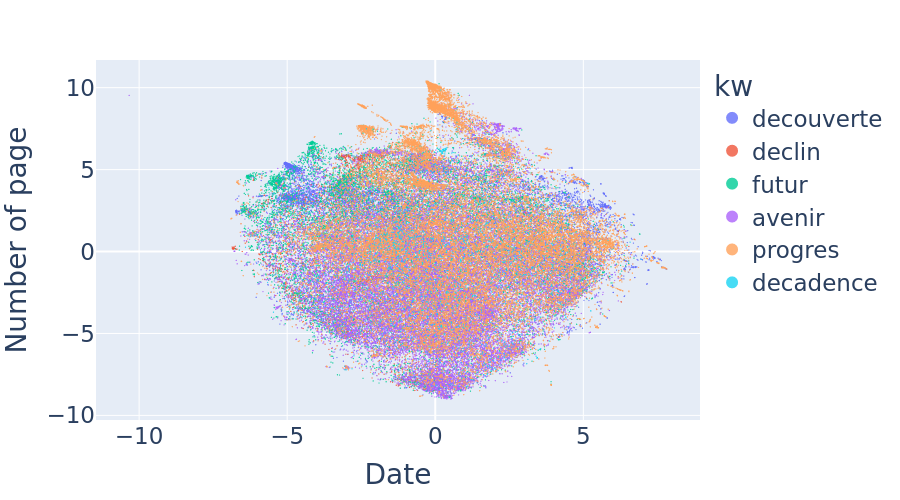

In [115]:
img = px.scatter(kwsDf,
                   x = 'TSNEx',
                   y = 'TSNEy',
                   color = 'kw')
                   #mode = 'markers',
                   #marker = {'size': 2},
                   #hoverinfo='skip')
img.update_traces(marker={'size': 1.5,'opacity' :0.8})
img.update_layout(
    #title="Plot Title",
    xaxis_title="Date",
    yaxis_title="Number of page",
    font_size = 23,
    legend= {'itemsizing': 'constant'}
    #legend_title="Legend Title",
)
Image(img.to_image(format="png", width=900, height=500))

In [125]:
test = ['Dans',
 'une',
 'petite_commune',
 'voisine',
 'de',
 'Paris',
 'vit',
 'un',
 'de',
 "l'Etat"]

In [126]:
model.predict_output_word(test)

[('banlieue', 5.237611e-05),
 ('Briand', 5.10461e-05),
 ('grève', 4.8292408e-05),
 ('automobile', 4.7542802e-05),
 ('région', 4.5178436e-05),
 ('kilomètres', 3.8115933e-05),
 ('église', 3.8084516e-05),
 ('ferme', 3.7353067e-05),
 ('gare', 3.7173846e-05),
 ("l'Etat", 3.6549776e-05)]